In [2]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt 

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [3]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=1
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())


In [16]:
vf = 0.74 
particles = 3 * 9 
r = 1
volume_particle = (4 / 3) * math.pi * (r ** 3) * particles
volume_box = volume_particle / vf
volume_box
Length = volume_box ** (1/3)
Length 

5.346548998127014

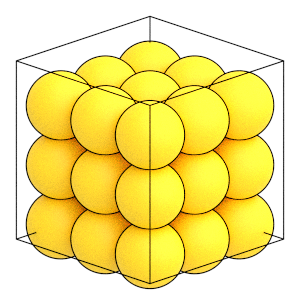

In [17]:
N_particles = particles
spacing = 1
K = math.ceil(N_particles ** (1 / 3))
L = Length * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, L, 0, 0, 0]
frame.particles.types = ['A']
render(frame)

In [20]:
fn = os.path.join(os.getcwd(), 'lattice_0.74.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='lattice_0.74.gsd', mode='x') as f:
    f.append(frame)

In [133]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='lattice_0.74.gsd')

In [134]:
mc = hoomd.hpmc.integrate.Sphere(default_d=1, default_a=0)
mc.shape["A"] = dict(diameter=2)
simulation.operations.integrator = mc
print('diameter = ', mc.shape["A"]["diameter"])

diameter =  2.0


In [135]:
fn = os.path.join(os.getcwd(), 'trajectory_expansion_74.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_expansion_74.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [136]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['d'],
    target=0.2,
    max_translation_move=1,
    trigger=hoomd.trigger.And(
        [hoomd.trigger.Periodic(100), hoomd.trigger.Before(simulation.timestep + 5000)]
    ),
)
simulation.operations.tuners.append(tune)

In [137]:
rho = simulation.state.N_particles / simulation.state.box.volume
rho 

0.17666198326427032

In [138]:
vf_f = (simulation.state.N_particles * (4/3) * math.pi * 1) / simulation.state.box.volume
vf_f

0.7399999850555128

In [139]:
target_volume_fraction = 0.01
volume_particle = (4 / 3) * math.pi * (1**3)
target_rho = target_volume_fraction / volume_particle
target_rho

0.0023873241463784303

In [140]:
final_rho = target_rho
final_volume = simulation.state.N_particles / final_rho
final_volume

11309.733552923255

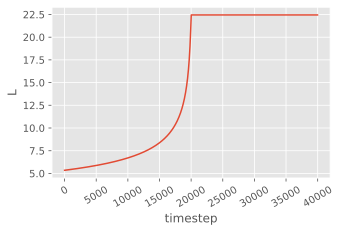

In [141]:
inverse_volume_ramp = hoomd.variant.box.InverseVolumeRamp(
    initial_box=simulation.state.box,
    final_volume=final_volume,
    t_start=simulation.timestep,
    t_ramp=20_000,
)

steps = range(0, 40000, 20)
y = [inverse_volume_ramp(step)[0] for step in steps]

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(steps, y)
ax.set_xlabel('timestep')
ax.set_ylabel('L')
ax.tick_params('x', labelrotation=30)
fig

In [142]:
box_resize = hoomd.update.BoxResize(
    trigger=hoomd.trigger.Periodic(10),
    box=inverse_volume_ramp, 
)
simulation.operations.updaters.append(box_resize)

In [143]:
simulation.run(20001)
mc.overlaps

*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 81 images per trial move, performance may slow.
This message will not be repeated.


0

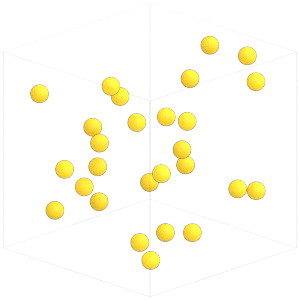

In [144]:
render(simulation.state.get_snapshot())

In [145]:
vf_c = (simulation.state.N_particles * (4/3) * math.pi * 1) / simulation.state.box.volume
vf_c

0.010000000000000002

In [146]:
gsd_writer.flush()

In [147]:
del(simulation)

In [148]:
traj_exp = gsd.hoomd.open('trajectory_expansion_74.gsd')
len(traj_exp)

200

In [149]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj_exp:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode='nearest', num_neighbors=12),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

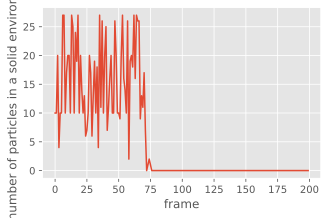

In [150]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
num_solid = numpy.array([numpy.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig

In [ ]:
# Seed 14 for 0.6 

In [414]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=14)
simulation.create_state_from_gsd(filename='trajectory_expansion_74.gsd')

In [415]:
mc = hoomd.hpmc.integrate.Sphere(default_d=1, default_a=0)
mc.shape["A"] = dict(diameter=2)
simulation.operations.integrator = mc
print('diameter = ', mc.shape["A"]["diameter"])

diameter =  2.0


In [416]:
fn = os.path.join(os.getcwd(), 'trajectory_compression_74.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_compression_74.gsd', trigger=hoomd.trigger.Periodic(500), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [417]:
tune = hoomd.hpmc.tune.MoveSize.scale_solver(
    moves=['d'],
    target=0.2,
    max_translation_move=1,
    trigger=hoomd.trigger.And(
        [hoomd.trigger.Periodic(100), hoomd.trigger.Before(simulation.timestep + 5000)]
    ),
)
simulation.operations.tuners.append(tune)

In [418]:
target_volume_fraction = 0.6
volume_particle = (4 / 3) * math.pi * (1**3)
target_rho = target_volume_fraction / volume_particle
target_rho

0.1432394487827058

In [419]:
final_rho = target_rho
final_volume = simulation.state.N_particles / final_rho
final_volume

188.49555921538757

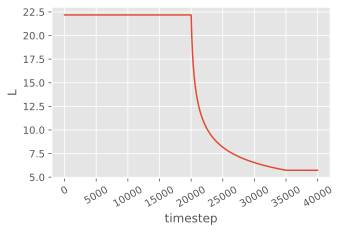

In [420]:
inverse_volume_ramp = hoomd.variant.box.InverseVolumeRamp(
    initial_box=simulation.state.box,
    final_volume=final_volume,
    t_start=simulation.timestep,
    t_ramp=15_000,
)

steps = range(0, 40000, 20)
y = [inverse_volume_ramp(step)[0] for step in steps]

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
ax.plot(steps, y)
ax.set_xlabel('timestep')
ax.set_ylabel('L')
ax.tick_params('x', labelrotation=30)
fig

In [421]:
box_resize = hoomd.update.BoxResize(
    trigger=hoomd.trigger.Periodic(10),
    box=inverse_volume_ramp, 
)
simulation.operations.updaters.append(box_resize)

In [422]:
simulation.run(15001)
mc.overlaps

*Warning*: Box size is too small or move size is too large for the minimum image convention.
Testing 81 images per trial move, performance may slow.
This message will not be repeated.


25

In [423]:
simulation.operations.updaters.remove(box_resize)
simulation.operations.tuners.remove(tune)
simulation.run(50e6)
mc.overlaps

0

In [424]:
if mc.overlaps == 0:
    pass

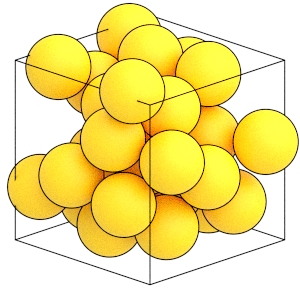

In [425]:
render(simulation.state.get_snapshot())

In [426]:
vf_cmp = (simulation.state.N_particles * (4/3) * math.pi * 1) / simulation.state.box.volume
vf_cmp

0.6

In [427]:
gsd_writer.flush()

In [428]:
del(simulation)

In [429]:
traj_cmp = gsd.hoomd.open('trajectory_compression_74.gsd')
len(traj_cmp)

100030

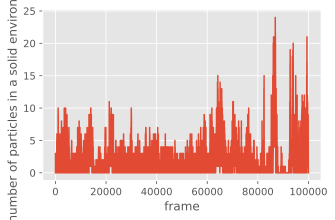

In [430]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj_cmp:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode='nearest', num_neighbors=12),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
num_solid = numpy.array([numpy.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig